In [37]:
import numpy as np

import cv2

import torch
from torch.nn import functional as F
from torchvision.transforms.functional import to_tensor

from models.unet_mini import UNetMini
from dataset.utils import show_array
from dataset.synthetic_card_image_dataset import SyntheticCardImageDataset


def load_image(img_path):
    return cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)


class ModelInference():
#     IMG_SIZE = (256, 256)
    IMG_SIZE = (512, 512)
    
    def __init__(self, weights_path):
        self._model = UNetMini(2)
#         self._model.cuda()
        state_dict = torch.load(weights_path)
        self._model.load_state_dict(state_dict)
        
    def predict(self, img):
        img = self.preprocess_image(img)
        with torch.no_grad():
            img = to_tensor(img)
            img = img[None, :]
#             img = img.to('cuda')
            output = self._model(img)
            output = F.softmax(output, dim=1)
        img_mask = output[0, 1].cpu().numpy()
        img_mask *= 255
        img_mask = img_mask.astype(np.uint8)
        return img_mask
        
    @staticmethod
    def preprocess_image(img):
        img = img.copy()

        if img.shape[0] != img.shape[1]:
            size = max(img.shape)
            new_img = np.zeros([size] * 2, dtype=np.uint8)
            y_delta, x_delta = ((size - np.array(img.shape)) / 2).astype(np.int)    
            new_img[y_delta:img.shape[0] + y_delta, x_delta:img.shape[1] + x_delta] = img
            img = new_img

        img = cv2.resize(img, ModelInference.IMG_SIZE)

        return img

In [38]:
model_inference = ModelInference('./artifacts/baseline2/epoch_model_150.pth')

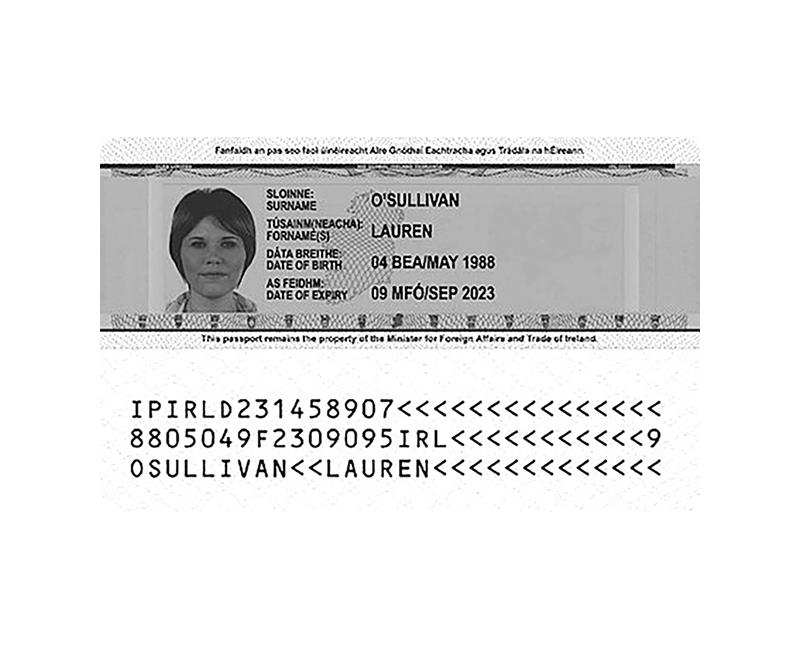

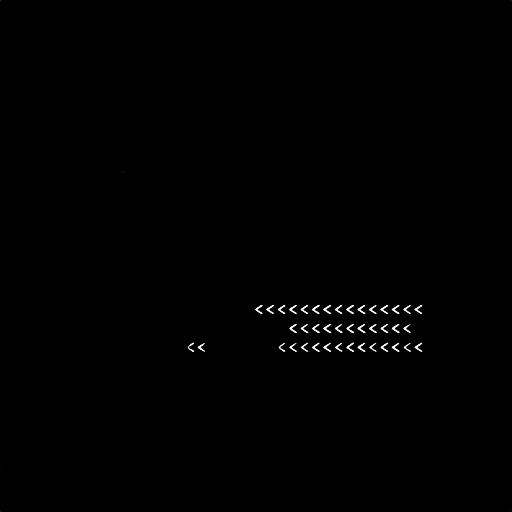

In [52]:
img_path = './problem_statement/sample6.jpg'
# img_path = './demo/images/sample_private_perspective_0.JPG'

img = load_image(img_path)

show_array(img)

img_pred = model_inference.predict(img)

show_array(img_pred)

In [40]:
dataset = SyntheticCardImageDataset(to_tensor=False)

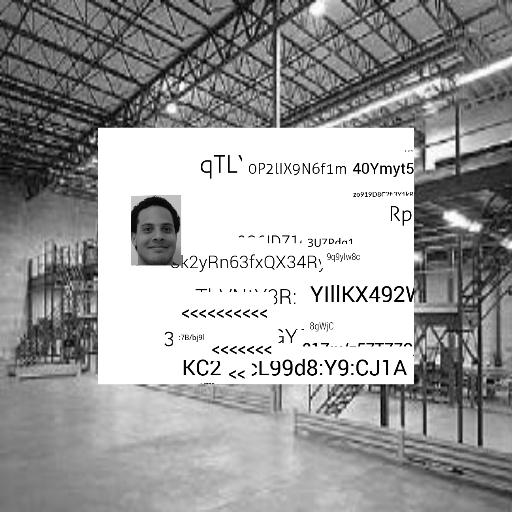

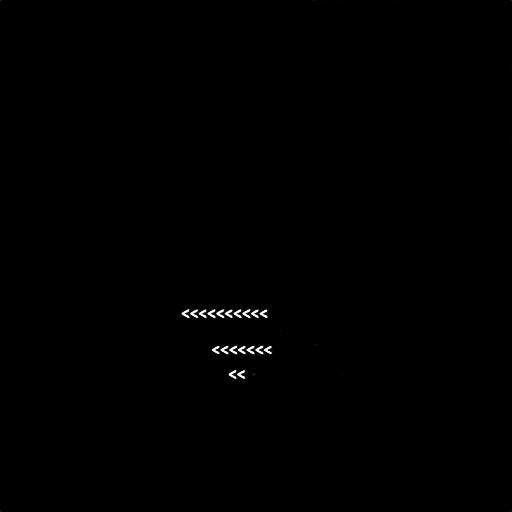

In [43]:
img, _ = dataset[0]

show_array(img)

img_pred = model_inference.predict(np.array(img))

# img_pred[img_pred < 128] = 0

show_array(img_pred)